In [31]:
import numpy as np
import pysindy as ps
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [288]:
def bio(data, t):
    F = 5
    B = 1
    R = 3
    
    n = len(data)
    result = np.empty(n)
    
    for i in range(0,n):
        sigma = 0
        for j in range (0,n):
            sigma = sigma + R*(adjacency[i,j])*data[i]*data[j]
        result[i] = F - B*data[i] - sigma
    
    return result

In [289]:
library_functions = [
    lambda : 1,
    lambda x : x,
    lambda x,y : x*y
]
library_function_names = [
    lambda : 1,
    lambda x : x,
    lambda x,y : '' + x + '.' + y
]

"""
input:
    an array with len=number_of_nodes
output: 
    and array with len=len(custom_library.get_feature_names())
example:
    input = [0., 0., 1., 1,]
    output = [1, data[0], data[1], data[2], data[3], 
            data[0]*data[1], data[0]*data[2], data[0]*data[3],
            data[1]*data[2], data[1]*data[3], data[2]*data[3]]
"""
def library_parser(data):
    n = len(data)
    result = [None] * int(1 + n + n*(n-1)/2)
    result[0] = 1
    for i in range(0,n):
        result[i+1] = data[i]
    index = 0
    for i in range(0,n):
        for j in range(i+1,n):
            index += 1
            result[n+index] = data[i]*data[j]
    return result

In [292]:
number_of_nodes = 10
#graph = nx.erdos_renyi_graph(number_of_nodes, 0.2)
#graph = nx.connected_watts_strogatz_graph(number_of_nodes, 4, 0.9)
graph = nx.scale_free_graph(number_of_nodes)
adjacency = nx.to_numpy_matrix(graph).A

dt = .01

t_train = np.arange(0, 100, dt)
x0_train = np.random.rand(number_of_nodes) * 10
x_train = odeint(bio, x0_train, t_train)

custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt)
model.print()

x0' = -517344.432 1 + -1117270.101 x2 + -1258288.751 x4 + -49552.806 x5 + 460412.311 x6 + 452837.624 x7 + 989629.270 x8 + 1091664.166 x9 + -33144.751 x0.x1 + -296347.158 x0.x2 + 167486.755 x0.x3 + -9005.867 x0.x4 + -310605.541 x0.x5 + 638856.335 x0.x6 + -1203507.016 x0.x7 + -761691.769 x0.x8 + 543882.592 x0.x9 + 93731.299 x1.x2 + -183023.439 x1.x3 + 1120184.612 x1.x4 + 1229368.038 x1.x5 + -370347.517 x1.x7 + -1045904.300 x1.x8 + -1061623.451 x1.x9 + -10386.933 x2.x3 + -252923.917 x2.x4 + -88531.894 x2.x5 + 499829.592 x2.x6 + 205839.835 x2.x7 + 752658.044 x2.x8 + 116798.153 x2.x9 + -409285.798 x3.x4 + -43168.087 x3.x5 + -69703.713 x3.x6 + 80922.185 x3.x7 + 127857.296 x3.x8 + 383310.851 x3.x9 + -39780.552 x4.x5 + 186028.938 x4.x8 + 15.365 x4.x9 + -518748.394 x5.x6 + 378744.701 x5.x7 + -187716.535 x5.x8 + -27017.357 x5.x9 + -129226.270 x6.x7 + 9275.855 x6.x9 + -193532.822 x7.x8 + -146914.816 x8.x9
x1' = 374540.769 x4 + -2338.536 x7 + -56061.663 x8 + -364496.292 x9 + 13504.946 x0.x2 + -136

In [294]:
def find_steady_state(X):
    prev_state = X[0]
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        prev_state = state
        if -0.0001 < max(np.amax(diff), np.amin(diff), key=abs) < 0.0001:
            return state

real_steady_state = find_steady_state(x_train)        
        
def bio_sindy(data, t):
    cf = library_parser(data)
    result = np.empty(len(data))
    for index in range(0, len(data)):
        sum = 0
        for i in range(0, len(cf)):
            sum += coefficients[index][i] * cf[i]
        result[index] = sum
    return result

coefficients = model.coefficients()
x_test = odeint(bio_sindy, x0_train, t_train)
sindy_steady_state = find_steady_state(x_test)

print('real_steady_state:', real_steady_state)
print('sindy_steady_state:', sindy_steady_state)

real_steady_state: [0.41957544 0.69994628 0.64790923 0.14014919 5.00923297 1.69852661
 1.14716651 1.61298717 1.69852654 5.00987435]
sindy_steady_state: [1.04252215 4.99007188 1.52596623 1.2275987  2.77293028 1.04253136
 0.80283645 1.22758908 1.23401083 1.52595748]


In [284]:
perturbation = np.empty(number_of_nodes)
perturbation[3] = 2
perturbed = np.add(sindy_steady_state, perturbation)

t_perturbed = np.arange(0, 50, dt)
x_perturbed = odeint(bio_sindy, perturbed, t_perturbed)
perturbed_steady_state = find_steady_state(x_perturbed)

print('perturbed_steady_state:', perturbed_steady_state)

perturbed_steady_state: [1.04252215 4.99007188 1.52596623 1.2275987  2.77293028 1.04253136
 0.80283645 1.22758908 1.23401083 1.52595748]


In [285]:
def flow(X):
    prev_state = X[0]
    result = np.empty((0,len(prev_state)))
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        result = np.vstack((result, diff))
        prev_state = state
        if -0.05 < max(np.amax(diff), np.amin(diff), key=abs) < 0.05:
            return result
    print('chaos state')
    return result
        
x_flow = flow(x_perturbed)

<Figure size 1152x648 with 0 Axes>

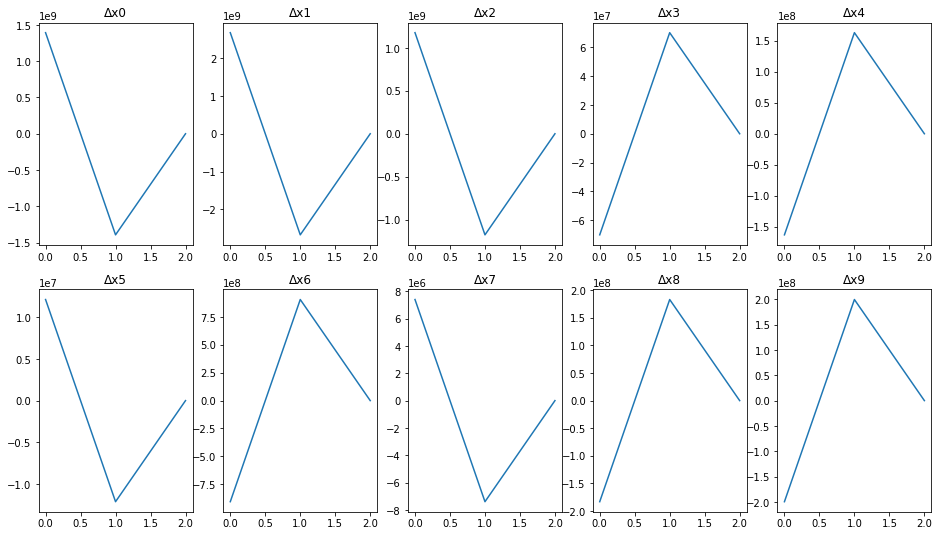

In [286]:
fpr = 5
plt.rcParams["figure.figsize"] = (16, 9)

plt.figure(1)
fig, axs = plt.subplots(int(number_of_nodes/fpr), fpr)
for i in range(0,number_of_nodes):
    axsi = axs[int(i/fpr), i%fpr]
    axsi.plot(x_flow[:,i])
    axsi.set_title('\u0394x'+str(i))
#     axsi.set_ylim(0.1,-0.1)
    

plt.show()

In [287]:
graph.degree

DiMultiDegreeView({0: 17, 1: 5, 2: 8, 3: 3, 4: 1, 5: 2, 6: 1, 7: 1, 8: 1, 9: 1})